## Problem Statement
We have labelled data for about 7K+ tweets in which there are positive and negative tweets. We will try to build a machine learning model which can detect if a tweet is positive and negative basis its tweet text. Since twitter data can be quite messy, we will do some preprocessing and apply different NLP steps to clean the data.

We will start with *removing punctuations, special chars and numbers*, since these are not much relevant to our positive/negative tweet prediction. We will then remove short words, **tokenize** the tweet into text and then apply the **porter stemmer** on the tokenized words. The stemmer will remove words with suffixes and bring down the unique count of words which are clean.

We will also plot two **Word Clouds** to see which words are prominent in positive/negative tweets.

We will finally apply **TF-IDF vectorizer** to assign relevant importance to tweeted words in context of whole corpus. This will weigh down unimportant words and bring the important words into spotlight which can swing the tweet sentiment towards positive or negative.

We finally conclude with simple **Logistic Regression **model to predict the tweet sentiment.

### Load necessary packages

In [3]:
import numpy as np
import pandas as pd
import re 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings
from nltk.stem.porter import *
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/twitter-tweets/test_oJQbWVk.csv
/kaggle/input/twitter-tweets/sample_submission_LnhVWA4.csv
/kaggle/input/twitter-tweets/train_2kmZucJ (1).csv


### Read train and test data

In [4]:
train_df = pd.read_csv('/kaggle/input/twitter-tweets/train_2kmZucJ (1).csv')
print(train_df.shape)
test_df = pd.read_csv('/kaggle/input/twitter-tweets/test_oJQbWVk.csv')
test_df.shape

(7920, 3)


(1953, 2)

In [5]:
comb_df = train_df.append(test_df, ignore_index=True)
comb_df.shape

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


(9873, 3)

### Remove punctuations, numbers and special characters

In [6]:
comb_df['clean_tweet'] = comb_df['tweet'].str.replace("[^a-zA-Z#]", " ")

In [7]:
comb_df.head(5)

,id,label,tweet,clean_tweet
0,1,0.0,#fingerprint #Pregnancy Test https://goo.gl/h1...,#fingerprint #Pregnancy Test https goo gl h ...
1,2,0.0,Finally a transparant silicon case ^^ Thanks t...,Finally a transparant silicon case Thanks t...
2,3,0.0,We love this! Would you go? #talk #makememorie...,We love this Would you go #talk #makememorie...
3,4,0.0,I'm wired I know I'm George I was made that wa...,I m wired I know I m George I was made that wa...
4,5,1.0,What amazing service! Apple won't even talk to...,What amazing service Apple won t even talk to...


### Remove short words with length less than equal to 3
This is necessary because words like 'oh', 'hmm' are not much relevant and can be removed

In [8]:
comb_df['clen_tweet'] = comb_df['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

### Tokenize the tweet text into separate words
Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [9]:
tokenized_tweet = comb_df['clean_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [#fingerprint, #Pregnancy, Test, https, goo, g...
1    [Finally, a, transparant, silicon, case, Thank...
2    [We, love, this, Would, you, go, #talk, #makem...
3    [I, m, wired, I, know, I, m, George, I, was, m...
4    [What, amazing, service, Apple, won, t, even, ...
Name: clean_tweet, dtype: object

### Stemming
Stemming is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word. For example, For example – “play”, “player”, “played”, “plays” and “playing” are the different variations of the word – “play”.

In [10]:
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [#fingerprint, #pregnanc, test, http, goo, gl,...
1    [final, a, transpar, silicon, case, thank, to,...
2    [We, love, thi, would, you, go, #talk, #makeme...
3    [I, m, wire, I, know, I, m, georg, I, wa, made...
4    [what, amaz, servic, appl, won, t, even, talk,...
Name: clean_tweet, dtype: object

In [11]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

comb_df['clean_tweet'] = tokenized_tweet

### Word Cloud of all tweets

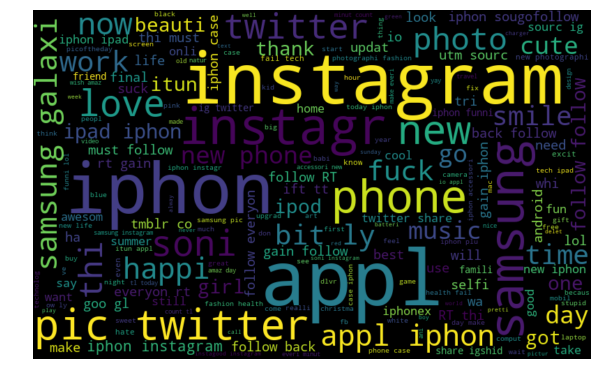

In [12]:
all_words = ' '.join([text for text in comb_df['clean_tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Word Cloud of negative tweets

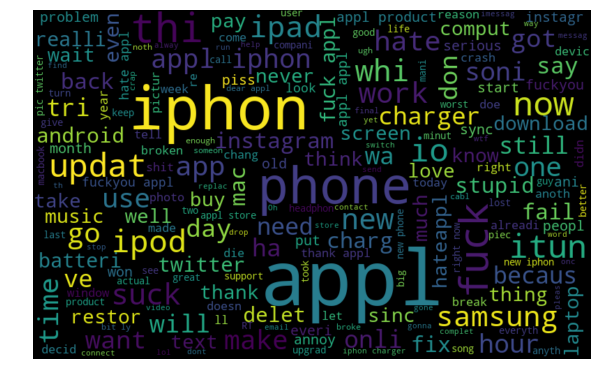

In [13]:
all_words = ' '.join([text for text in comb_df[comb_df['label'] == 1]['clean_tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### TF-IDF Vectorization
This is  based on the frequency method but it is different to the bag-of-words approach in the sense that it takes into account, not just the occurrence of a word in a single document (or tweet) but in the entire corpus.

TF-IDF works by penalizing the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.

Let’s have a look at the important terms related to TF-IDF:

TF = (Number of times term t appears in a document)/(Number of terms in the document)
IDF = log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.
TF-IDF = TF*IDF

In [14]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(comb_df['clean_tweet'])

### Separating train and test data again

In [15]:
train_data = tfidf[:train_df.shape[0], :]
test_data = tfidf[train_df.shape[0]:, :]
print(train_data.shape)
print(test_data.shape)

(7920, 1000)
(1953, 1000)


In [16]:
x_train, x_test, y_train, y_test = train_test_split(train_data, train_df['label'], random_state=0, test_size=0.2)

### Apply a simple Logistic Regression on the tf-idf data

In [17]:
log_model = LogisticRegression()
log_model.fit(x_train, y_train)
y_test_pred = log_model.predict(x_test)
print(f1_score(y_test, y_test_pred))

0.7525252525252525


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Final Predictions

In [20]:
predictions = log_model.predict(test_data)
predictions = predictions.astype(int)
output_df = pd.DataFrame({'id': test_df['id'], 'label': predictions})
output_df.head(5)

,id,label
0,7921,1
1,7922,1
2,7923,1
3,7924,1
4,7925,1


In [21]:
output_df.to_csv('tweet_sentiment_submission.csv', index=False)

## Leaderboard Score = 0.885

<a href="tweet_sentiment_submission.csv"> Download File </a>